In [2]:
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split

In [3]:
import os
from PIL import Image
from tensorflow.keras.utils import img_to_array

In [4]:
tumor = [('glioma_tumor', 0),('meningioma_tumor', 1),('no_tumor', 2),('pituitary_tumor', 3)]
path1 = 'C:/Users/user/Desktop/hirt/Training/'
path2 = 'C:/Users/user/Desktop/hirt/Testing/'

# Image Processing

In [5]:
Path = [
    'C:/Users/user/Desktop/hirt/Training/glioma_tumor'  ,
    'C:/Users/user/Desktop/hirt/Training/meningioma_tumor',
    'C:/Users/user/Desktop/hirt/Training/no_tumor'    ,
    'C:/Users/user/Desktop/hirt/Training/pituitary_tumor/p (122).jpg',
]

In [6]:
def display (img_array) :
    
    dim = 10
    
    plt.figure(figsize  = (dim , dim))
    for i, img in enumerate(img_array) :
        plt.subplot(2, 2, i+1)
        plt.imshow(img,'gray')
        plt.title(img.shape)
        
    plt.show()

In [7]:
def get_array (path) :
    
    X = []
    y = []
    
    for typ, val in tumor :
        for image in os.listdir(path+typ) :
            img = cv2.resize(cv2.imread(path+typ+'/'+image, cv2.IMREAD_GRAYSCALE), (200,200))
            
            # create arrays
            X.append(img_to_array( Image.fromarray(img)))
            y.append(val)
    return X, y

In [9]:
display(image_array)

<Figure size 720x720 with 0 Axes>

# Convert Images to Numpy arrays

In [10]:
X_train, y_train = get_array(path1)

In [11]:
X_test , y_test  = get_array(path2)

In [12]:
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

# Scale the arrays

In [13]:
X_train = np.array(X_train)
X_train/= 255.0

In [14]:
y_train = np.array(keras.utils.to_categorical(y_train))

In [15]:
X_test = np.array(X_test)
X_test/= 255.0

In [16]:
y_test = np.array(keras.utils.to_categorical(y_test))

In [17]:
print(X_train.shape)
print(y_train.shape)

(2870, 200, 200, 1)
(2870, 4)


In [18]:
print(X_test.shape)
print(y_test.shape)

(394, 200, 200, 1)
(394, 4)


In [19]:
info = {0 : 'Glioma tumor', 1 : 'Meningioma tumor', 2 : 'No tumor', 3 : 'Pituitary tumor'}

# Plots of some training samples

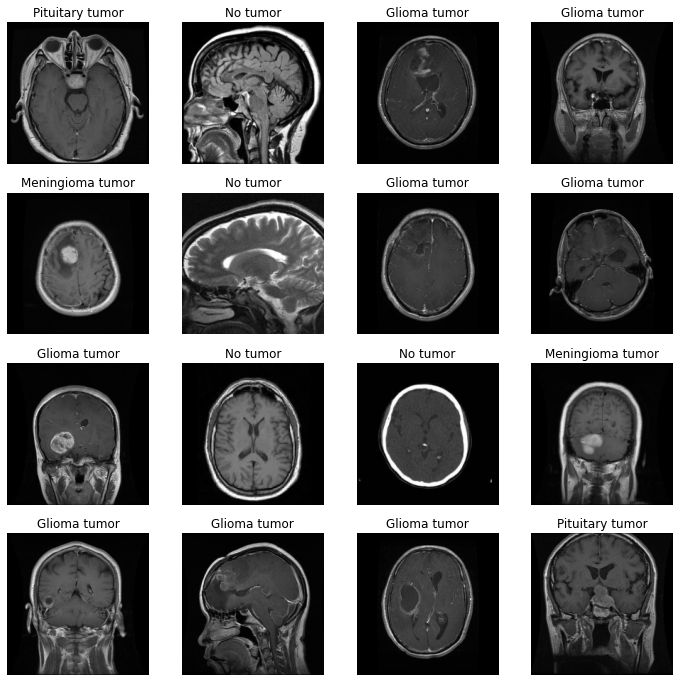

In [20]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(0, 2870)
    plt.imshow(X_train[x], 'gray')
    plt.title(info[np.argmax(y_train[x])])
    plt.axis('off')
plt.show()

# Class frequency distribution

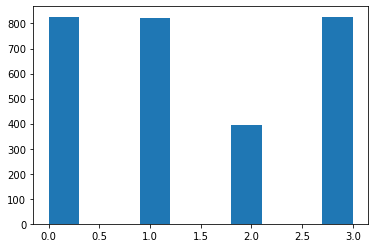

In [21]:
plt.hist(np.argmax(y_train, axis = 1))
plt.show()

# Synthetic Minority Oversampling
**Glioma tumor, Meningioma tumor** and **Pituitary tumor** almost same number of datasets ie. 826, 822 and 827 respectively. But the label **no_tumor** has only 395 samples. Since the number of samples for **no_tumor** class is less, let's oversample that class using SMOTE from imblearn package.

In [22]:
print(X_train.shape)
print(y_train.shape)

(2870, 200, 200, 1)
(2870, 4)


In [23]:
X_train = np.reshape(X_train, (2870, 200*200*1))
print(X_train.shape)
print(y_train.shape)

(2870, 40000)
(2870, 4)


In [24]:
!pip install -U imbalanced-learn

In [25]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state = 1, k_neighbors = 5).fit_resample(X_train, y_train)

In [26]:
print(X_train.shape)
print(y_train.shape)

(3308, 40000)
(3308, 4)


In [27]:
X_train = np.reshape(X_train, (3308, 200, 200, 1))
print(X_train.shape)
print(y_train.shape)

(3308, 200, 200, 1)
(3308, 4)


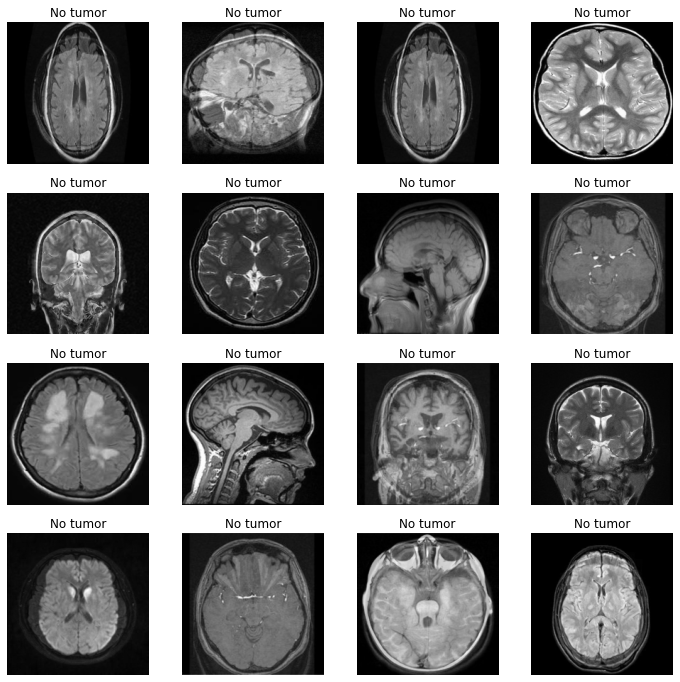

In [28]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(2870, 3308)
    plt.imshow(X_train[x], 'gray')
    plt.title(info[np.argmax(y_train[x])])
    plt.axis('off')
plt.show()

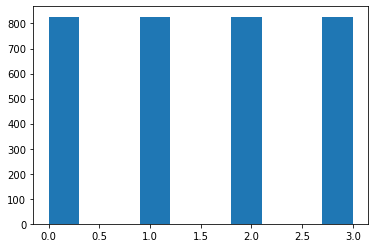

In [32]:
plt.hist(np.argmax(y_train, axis = 1))
plt.show()

# Images of test samples

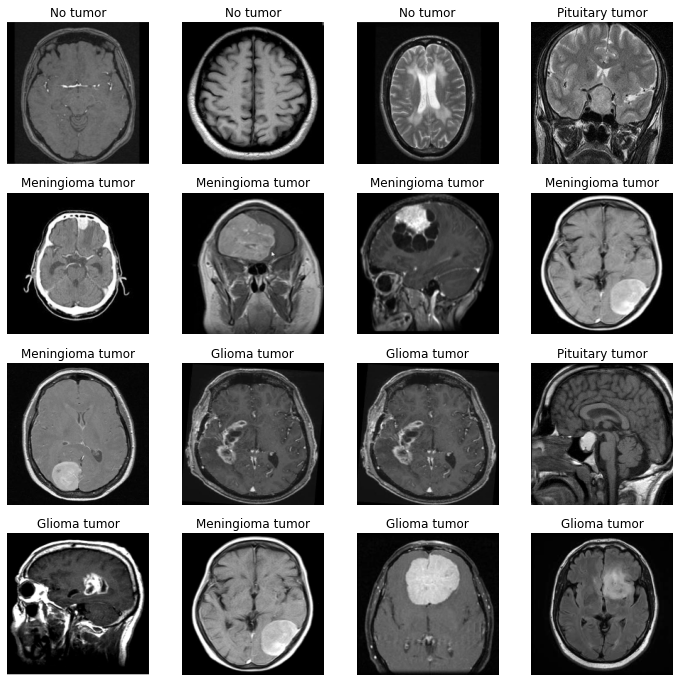

In [33]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(0,390)
    plt.imshow(X_test[x],'gray')
    plt.title(info[np.argmax(y_test[x])])
    plt.axis('off')
plt.show()

# Model creation and training

In [34]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Conv2D

In [35]:
def conv_layer (filterx) :
    
    model = Sequential()
    model.add(Conv2D(filterx, (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid'))
    model.add(BatchNormalization())
    
    return model

In [36]:
def dens_layer (hiddenx) :
    
    model = Sequential()
    model.add(Dense(hiddenx, activation = 'relu', kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    return model

In [37]:
def cnn (filter1, filter2, filter3, hidden1, hidden2) :
    
    model = Sequential()
    
    model.add(Input((200,200,1,)))
    model.add(conv_layer(filter1))
    model.add(conv_layer(filter2))
    model.add(conv_layer(filter3))
    
    model.add(Flatten())
    model.add(dens_layer(hidden1))
    model.add(dens_layer(hidden2))
    model.add(Dense(4, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])
    
    return model

# Use ImageDataGenerator for image data augmentation

In [38]:
print(X_train.shape)
print(y_train.shape)

(3308, 200, 200, 1)
(3308, 4)


In [39]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(zoom_range = [0.85, 1.0], rotation_range = 3)

In [40]:
gen.fit(X_train)
train_gen = gen.flow(X_train, y_train, batch_size = 32)

In [41]:
trainX, trainy = train_gen.next()

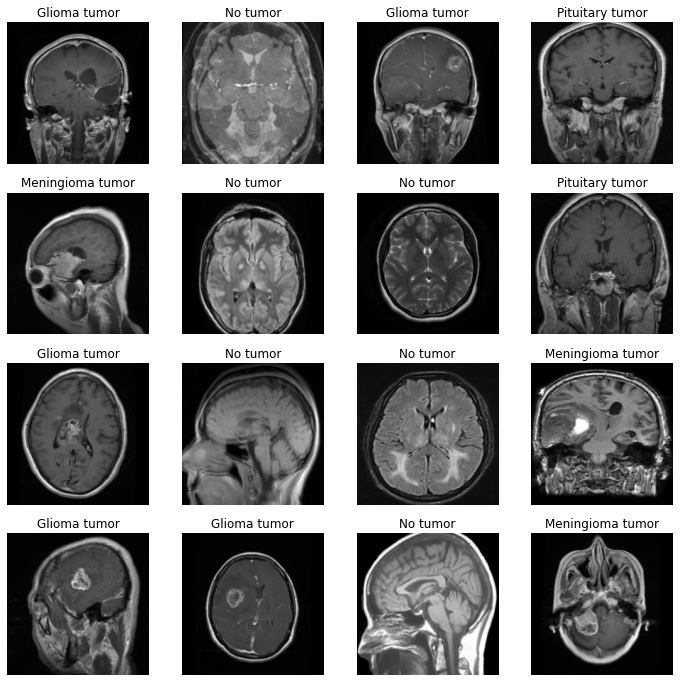

In [42]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    plt.imshow(trainX[i], 'gray')
    plt.title(info[np.argmax(trainy[i])])
    plt.axis('off')
plt.show()

## Model implementation

In [43]:
from keras.callbacks import ModelCheckpoint
checkp = ModelCheckpoint('./brain_model.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1)

In [44]:
model = cnn(128, 64, 32, 128, 64)

In [45]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 100, 100, 128)     1792      
                                                                 
 sequential_2 (Sequential)   (None, 50, 50, 64)        74048     
                                                                 
 sequential_3 (Sequential)   (None, 25, 25, 32)        18592     
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 sequential_4 (Sequential)   (None, 128)               2560640   
                                                                 
 sequential_5 (Sequential)   (None, 64)                8512      
                                                                 
 dense_2 (Dense)             (None, 4)                 2

# Prediction

In [46]:
from keras.models import load_model
model = load_model('./brain_model.h5')

In [47]:
pred = model.predict(X_test)

13/13 [==============================] - 21s 2s/step


In [48]:
print(pred[0:3,:])

[[0.00453225 0.00403599 0.29571593 0.69571584]
 [0.01250144 0.00378377 0.42988703 0.5538277 ]
 [0.02294184 0.00489407 0.25931486 0.71284914]]


In [49]:
temp = np.argmax(pred, axis = 1)
pred = np.zeros(pred.shape)

In [50]:
pred[np.arange(pred.shape[0]), temp] = 1

In [51]:
print(pred[0:3,:])
print(y_test[0:3,:])

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


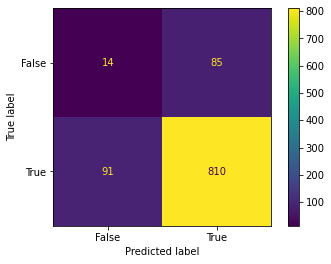

In [67]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

y_test = numpy.random.binomial(1,.9,size = 1000)
pred = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(y_test, pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()